In [1]:
import os
import sys
import numpy as np
import essentia.standard as ess
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import csv

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import IPython.display as ipd

In [30]:
#Reading a sample wave file
soundsDIR = '../gnaimeh/fulltracks/'
fs = 44100

x = ess.MonoLoader(filename = soundsDIR + 'stilvortalentarchive/2020/01-2020/09/Brigado Crew - Equilibrium (Stil Vor Talent)/02-Brigado Crew - Ritual (Original Mix)-electrobuzz.net.mp3', sampleRate = fs)()
#Normalize maximum amplitude to 1
x = x / np.max(np.abs(x))
#Setting the parameters
windowSize = 1024
hopSize = 512
startIndexes = np.arange(0, x.size - windowSize, hopSize, dtype = int)#frame/window start indexes
numWindows = startIndexes.size

In [ ]:
#Plot time-domain signal and the energy signal
plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
plt.plot(x)
plt.title('Original sound signal')
plt.ylabel('amplitude')
plt.xlabel('sample indexes')
plt.axis('tight')


#Your code starts here----------
#Write the code to perform windowing and feature estimation
# - features to be computed: energy and maximum amplitude
# - plot energy and maximum amplitude

NRG = np.zeros_like(startIndexes, dtype = float)#initializing the array for keeping energy values
maxVal = np.zeros_like(startIndexes, dtype = float)#initializing the array for maximum values

#Windowing (use variables: startIndexes and numWindows)
for k in range(numWindows):
    startInd = startIndexes[k]
    x_win = x[startInd : startInd + windowSize]
    NRG[k] = np.sum(np.power(x_win, 2))
    maxVal[k] = np.max(np.abs(x_win))

#Your code ends here----------

#Let's normalize the arrays for the simplicity of viewing them together
NRG = NRG / np.max(NRG)
maxVal = maxVal / np.max(maxVal)
dervNRG = NRG[1:] - NRG[:-1]#let's also compute the derivative of the energy and plot together
dervNRG[dervNRG < 0] = 0
plt.subplot(1, 2, 2)
plt.plot(NRG,label = 'Normalized energy')
plt.plot(maxVal, 'k', label = 'Max-val')
plt.plot(dervNRG, 'r', label = 'NRG derivative')
plt.title('Energy vs maxima')
plt.ylabel('amplitude')
plt.xlabel('sample indexes')
plt.axis('tight')
plt.legend(loc = 'best')
ipd.Audio(x, rate = fs)

In [4]:
print(np.argmax(dervNRG))

20594


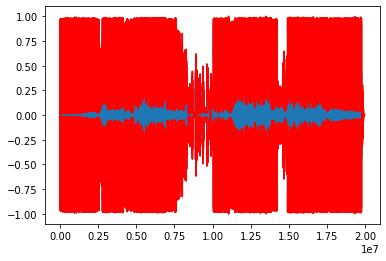

In [5]:
#Optional: Plotting maximum amplitude in sync with the waveform
plt.plot(x)
plt.plot(np.arange(maxVal.size) * (x.size / maxVal.size), maxVal, 'r')
plt.plot(np.arange(maxVal.size) * (x.size / maxVal.size), -maxVal, 'r')

In [6]:
# Raw-data preprocess analysis parameters
fs = 44100
windowSize = 4096 * 4
hopSize = 4096 * 2
NRG_threshold_ratio = 0.01 #threshold expressed as ratio with respect to the maximum value
#Let's put in a container to be able to use as a single argument in function calls
params = {"fs":fs, "windowSize":windowSize, "hopSize":hopSize, "NRG_threshold_ratio": NRG_threshold_ratio}

In [7]:
#Function definition
def split_file(filename, params):
    '''Function to define split boundaries based on a fixed energy threshold
    '''
    x = ess.MonoLoader(filename = filename, sampleRate = fs)()
    NRG = [];
    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
        NRG.append(ess.Energy()(frame))
    NRG = np.array(NRG)
    NRG = NRG / np.max(NRG)
    
    #Applying energy threshold to decide wave split boundaries
    split_decision_func = np.zeros_like(NRG)
    split_decision_func[NRG > NRG_threshold_ratio] = 1
    #Setting segment boundaries
    #Inserting a zero at the beginning since we will decide the transitions using a diff function
    split_decision_func = np.insert(split_decision_func, 0, 0)
    diff_split_decision = np.diff(split_decision_func)
    #Start indexes: transition from 0 to 1
    start_indexes = np.nonzero(diff_split_decision > 0)[0] * hopSize
    #Stop indexes: transition from 1 to 0
    stop_indexes = np.nonzero(diff_split_decision < 0)[0] * hopSize
    return (x, NRG, start_indexes, stop_indexes)

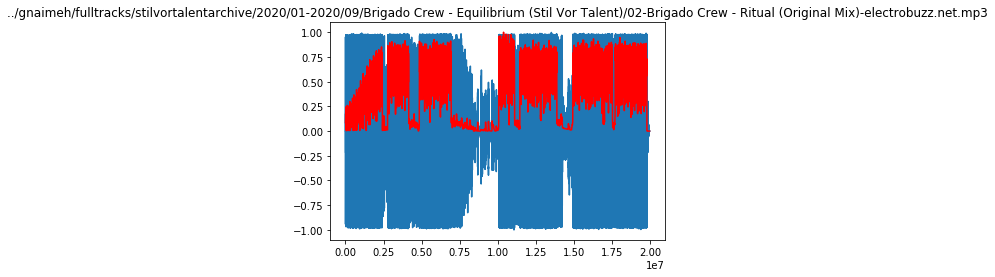

In [8]:
soundsDIR='../gnaimeh/fulltracks/'
filename = soundsDIR + 'stilvortalentarchive/2020/01-2020/09/Brigado Crew - Equilibrium (Stil Vor Talent)/02-Brigado Crew - Ritual (Original Mix)-electrobuzz.net.mp3'
(x, NRG, start_indexes, stop_indexes) = split_file(filename, params)
        #Plotting functions for checking the split decisions
        
plt.title(filename)
plt.plot(x, label = 'sound waveform')
plt.plot(np.arange(NRG.size) * hopSize, NRG, 'r', label = 'NRG')
#plt.plot(np.arange(split_decision_func.size) * hopSize, split_decision_func,'g', label = 'split function')
#plt.vlines(start_indexes, ymin = -0.5, ymax = 0, colors='b', linestyles='solid', label='Segment start')
#plt.vlines(stop_indexes, ymin = -0.5, ymax = 0, colors='k', linestyles='dashed', label='Segment stop')



In [9]:
NRGpeak = np.max(NRG)
print(NRGpeak)

1.0


In [10]:
z = np.argmax(NRG)
print(z)

1266


In [11]:
#we shall define the position in time (s) of this maximum NRG value
time = z*hopSize/fs
print(time)

235.1717006802721


In [12]:
nsamples = np.sum(abs(x))

In [13]:
print(nsamples)

3822010.0


In [14]:
# total duration of the whole track in seconds
t= (x.size)/fs
print(t)

452.6769841269841


In [34]:
count = 0
count_songs = 0
labels = []
labels_dict = dict()


for root, dirs, files in os.walk ('../gnaimeh/tempft/'):
    count += 1
    if count==1:
        labels = [label for label in dirs if not label.startswith('.')]
    else:
        break
        
for l in labels:
    count_songs = 0
    for root, dirs, files in os.walk('../gnaimeh/tempft/'+l):
        for file in files:
            if  file.endswith('.mp3'):
                count_songs += 1
    
                
    print(l, " songs ", count_songs)       
    if "name" in labels_dict:
        labels_dict["name"].append(l)
        labels_dict['number_songs'].append(count_songs)
    else:
        labels_dict["name"] = [l]
        labels_dict["number_songs"] = [count_songs]
        

ninjatunearchive  songs  610


In [20]:
######
def NRG_time(filename, params):
    '''Function to define split boundaries based on a fixed energy threshold
    '''
    x = ess.MonoLoader(filename = filename, sampleRate = fs)()
    NRG = [];
    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
        NRG.append(ess.Energy()(frame))
    NRG = np.array(NRG)
    NRG = NRG / np.max(NRG)
    tNRG = (np.argmax(NRG))*hopSize/fs
    t_total= (x.size)/fs
    pos_NRG = (tNRG/t_total)*100
    return (pos_NRG)

25.0 %


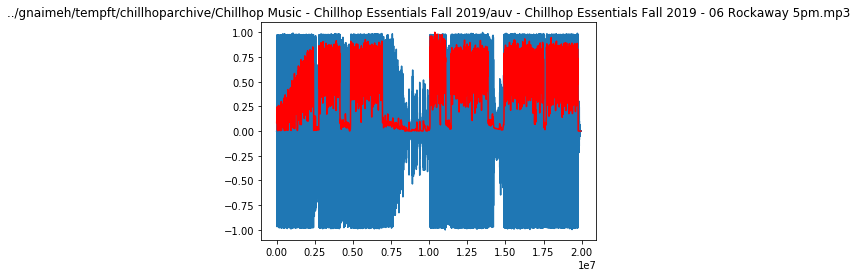

In [23]:
soundsDIR='../gnaimeh/tempft/'
filename = soundsDIR + 'chillhoparchive/Chillhop Music - Chillhop Essentials Fall 2019/auv - Chillhop Essentials Fall 2019 - 06 Rockaway 5pm.mp3'
(pos_NRG) = NRG_time(filename, params)
        
        
plt.title(filename)
plt.plot(x, label = 'sound waveform')
plt.plot(np.arange(NRG.size) * hopSize, NRG, 'r', label = 'NRG')
print(round(pos_NRG,0),'%')

In [35]:
data_file = os.path.join('../gnaimeh/tempft/'+ 'data_NRG_ninjatune.csv')
countlabel = 0
count = 0

nfiles = min(labels_dict["number_songs"])

with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join('pos_NRG' + 'label')+ '\n'
    writer.write(line2write)  
    
    for l in labels_dict['name']:
        print(l)
        for root, dirs, files in os.walk ('../gnaimeh/tempft/'+l):
            if count >= nfiles:
                count = 0
                break
            for file in files: 
                if not file.startswith('.') and file.endswith('.mp3'):                                  
                    if count < nfiles:
                        count += 1
                        if count % 20 == 0:
                            print(count, "files processed, current file: ",file)
       
                        pos_NRG=NRG_time(root+'/'+file, params)

                        line2write = str(pos_NRG) + ',' + l + '\n'
                        writer.write(line2write)

                    else:
                        print(l)
                        print(count)
                        print("Another label")
                        break



print('Files processed ', count)

ninjatunearchive
20 files processed, current file:  Seven Davis Jr - Dancing On The Sun (Instrumental) [Ninja Tune].mp3
40 files processed, current file:  Max Graef; Glenn Astro - Magic Johnson (Byron The Aquarius live mix) [Ninja Tune].mp3
60 files processed, current file:  Bicep - Drift (Original Mix) [Ninja Tune].mp3
80 files processed, current file:  Nathan Fake - PROVIDENCE [Ninja Tune].mp3
100 files processed, current file:  Bicep - Aura (12' Mix) [Ninja Tune].mp3
120 files processed, current file:  Young Fathers - Picking You (Original Mix)_Ninja Tune.mp3
140 files processed, current file:  03-Marie Davidson - The Psychologist (Original Mix)-electrobuzz.net.mp3
160 files processed, current file:  10 - Desert Father (Modeselektor Edit) (Monkeytown x Ninja Tune)-electrobuzz.net.mp3
180 files processed, current file:  Nathan Fake - CONNECTIVITY (Olga Wojciechowska Rework) [Ninja Tune;Ninja Tune]-electrobuzz.net.mp3
200 files processed, current file:  Nathan Fake, Raphaelle - RVK fe

In [ ]:
print("Sample plots for waveform versus energy")

file_indexes = [0, 1, 2]
for file_ind_inlist in file_indexes:
    plt.figure(file_ind_inlist, figsize=(5 * filename, 3))
    for i, filename in enumerate(inst_files.keys()):
        sample_file = inst_files[instrument][file_ind_inlist]
        (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
        #Plotting functions for checking the split decisions
        plt.subplot(1,num_instruments,(i+1))
        plt.title(instrument)
        plt.plot(x, label = 'sound waveform')
        plt.plot(np.arange(NRG.size) * hopSize, NRG, 'g', label = 'NRG')
        plt.plot(np.arange(split_decision_func.size) * hopSize, split_decision_func,'r', label = 'split function')
        plt.vlines(start_indexes, ymin = -0.5, ymax = 0, colors='b', linestyles='solid', label='Segment start')
        plt.vlines(stop_indexes, ymin = -0.5, ymax = 0, colors='k', linestyles='dashed', label='Segment stop')

plt.legend(loc="best");

In [ ]:
features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                          lowlevelFrameSize = 2048,
                                                          lowlevelHopSize = 1024,
                                                          lowlevelStats = ['mean', 'stdev'])(filename)

In [14]:
scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

In [61]:
#Extracting features and writing in data.csv file in the segments folder
#  each line in the data.csv file represents a sample with features and the class information as the last element
soundsDIR = '../gnaimeh/fulltracks/'
data_file = os.path.join(soundsDIR,'dataNRG.csv')

with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['filename']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    
    features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                          lowlevelFrameSize = 2048,
                                                          lowlevelHopSize = 1024,
                                                          lowlevelStats = ['mean', 'stdev'])(filename)
    selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
    line2write = str(selected_features)[1:-1] + ',' + filename + '\n'
    writer.write(line2write)


In [15]:
import pandas as pd

In [63]:
#Read data
data = pd.read_csv(data_file)
#Let's see the first lines of our data
data.head()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,...,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,filename
0,0.889453,14.677717,6.948937,0.207273,0.129874,105.040939,232.385071,5.34889,6.042965,24.061338,...,3663.654297,1.739452,1.103705,7598754.0,2855791.0,0.523705,0.571519,0.079536,0.083991,../gnaimeh/fulltracks/stilvortalentarchive/202...


In [17]:
file ='../gnaimeh/boc_60s/mordarchive/00-Charlton - Face Recognition (Original Mix)-electrobuzz.net/00-Charlton - Face Recognition (Original Mix)-electrobuzz.net-c0.mp3'
features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                  lowlevelFrameSize = 2048,
                                                  lowlevelHopSize = 1024,
                                                  tonalStats=['mean', 'stdev'],
                                                  rhythmStats=['mean', 'stdev'],
                                                  lowlevelStats = ['mean', 'stdev']) (file)
                                              
                                
scalar_descriptors = [descriptor for descriptor in features.descriptorNames() 
if not 'metadata' in descriptor and isinstance(features[descriptor], float)]

print("Subset of features to be considered:\n",scalar_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

In [28]:
soundsDIR = '../gnaimeh/boc_60s/bar25archive/01-Kermesse - El Solo (Original Mix)-electrobuzz.net'
data_file = os.path.join(soundsDIR,'dataNRG.csv')
countlabel = 0
count = 0
#nfiles = 290
#nfiles = min(labels_dict["number_songs"])

with open(data_file, 'w') as writer:
    line2write = ','.join(scalar_descriptors).replace('lowlevel.','') + ',label' '\n'
    writer.write(line2write)    
    
    
    for root, dirs, files in os.walk ('../gnaimeh/boc_60s/'):
            if count >= nfiles:
                count = 0
                break
    for file in files: 
        if not file.startswith('.') and file.endswith('.mp3'):                                  
            if count < nfiles:
                count += 1
                if count % 20 == 0:
                    print(count, "files processed, current file: ",file)
       
        features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      tonalStats=['mean', 'stdev'],
                                                      rhythmStats=['mean', 'stdev'],
                                                      lowlevelStats = ['mean', 'stdev'])(root+'/'+file)

        selected_features = [features[descriptor] for descriptor in scalar_descriptors]
        line2write = str(selected_features)[1:-1] + ',' + filename + '\n'
        writer.write(line2write)


print('Files processed ', count)

Files processed  9


In [34]:
#Read data
data = pd.read_csv(data_file)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
#Let's see the first lines of our data
print(data)

   average_loudness  barkbands_crest.mean  barkbands_crest.stdev  \
0          0.966883             17.549534               6.330570   
1          0.981189             16.763323               6.321404   
2          0.980007             17.238228               6.149115   
3          0.979834             17.456453               6.112474   
4          0.942071             16.795992               6.330127   
5          0.968594             17.957422               5.801830   
6          0.978147             15.964144               6.323431   
7          0.979833             18.966869               5.565535   
8          0.980110             20.965567               4.867420   

   barkbands_flatness_db.mean  barkbands_flatness_db.stdev  \
0                    0.245947                     0.117666   
1                    0.216236                     0.106561   
2                    0.197947                     0.094461   
3                    0.246995                     0.116475   
4        

In [ ]:
soundsDIR = '../gnaimeh/boc_60s/bar25archive/01-Kermesse - El Solo (Original Mix)-electrobuzz.net'
data_file = os.path.join(soundsDIR,'dataNRG.csv')
countlabel = 0
count = 0
#nfiles = 290
#nfiles = min(labels_dict["number_songs"])

with open(data_file, 'w') as writer:
    line2write = ','.join(scalar_descriptors).replace('lowlevel.','') + ',label' '\n'
    writer.write(line2write)    
    
    
    for root, dirs, files in os.walk ('../gnaimeh/boc_60s/'):
            if count >= nfiles:
                count = 0
                break
    for file in files: 
        if not file.startswith('.') and file.endswith('.mp3'):                                  
            if count < nfiles:
                count += 1
                if count % 20 == 0:
                    print(count, "files processed, current file: ",file)
       
        features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      tonalStats=['mean', 'stdev'],
                                                      rhythmStats=['mean', 'stdev'],
                                                      lowlevelStats = ['mean', 'stdev'])(root+'/'+file)

        selected_features = [features[descriptor] for descriptor in scalar_descriptors]
        line2write = str(selected_features)[1:-1] + ',' + filename + '\n'
        writer.write(line2write)


print('Files processed ', count)